## Install, Import, Load Model

In [0]:
!pip install --quiet lucid==0.3.8

import numpy as np
import scipy.ndimage as nd
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

In [0]:
model = models.InceptionV1()
model.load_graphdef()

print(model.labels)



W0905 11:22:54.855896 139686543935360 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/reading.py:126: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0905 11:22:54.859723 139686543935360 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/loading.py:72: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



[u'dummy', u'kit fox', u'English setter', u'Siberian husky', u'Australian terrier', u'English springer', u'grey whale', u'lesser panda', u'Egyptian cat', u'ibex', u'Persian cat', u'cougar', u'gazelle', u'porcupine', u'sea lion', u'malamute', u'badger', u'Great Dane', u'Walker hound', u'Welsh springer spaniel', u'whippet', u'Scottish deerhound', u'killer whale', u'mink', u'African elephant', u'Weimaraner', u'soft-coated wheaten terrier', u'Dandie Dinmont', u'red wolf', u'Old English sheepdog', u'jaguar', u'otterhound', u'bloodhound', u'Airedale', u'hyena', u'meerkat', u'giant schnauzer', u'titi', u'three-toed sloth', u'sorrel', u'black-footed ferret', u'dalmatian', u'black-and-tan coonhound', u'papillon', u'skunk', u'Staffordshire bullterrier', u'Mexican hairless', u'Bouvier des Flandres', u'weasel', u'miniature poodle', u'Cardigan', u'malinois', u'bighorn', u'fox squirrel', u'colobus', u'tiger cat', u'Lhasa', u'impala', u'coyote', u'Yorkshire terrier', u'Newfoundland', u'brown bear', u

In [0]:
# model layers
models.InceptionV1.layers

[Layer (belonging to InceptionV1) <conv2d0: 64> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <conv2d1: 64> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <conv2d2: 192> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed3a: 256> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed3b: 480> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed4a: 508> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed4b: 512> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed4c: 512> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed4d: 528> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed4e: 832> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed5a: 832> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <mixed5b: 1024> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([set(['conv'])]),
 Layer (belonging to InceptionV1) <nn0: 1024> ([set(['dense'])]),
 Layer (belonging to InceptionV1) <softmax

# **Visualizaciones báiscas: neurona y filtro**

W0905 11:22:55.031280 139686543935360 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:88: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0905 11:22:55.246000 139686543935360 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/param/spatial.py:54: The name tf.spectral.irfft2d is deprecated. Please use tf.signal.irfft2d instead.

W0905 11:22:55.259934 139686543935360 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:223: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 11:22:55.260838 139686543935360 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:241: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0905 11:22:55.262283 139686543935360 deprecation_wrapper.py:119] From /usr/local/lib

512 [2986.4387]



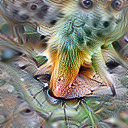

512 701.06555



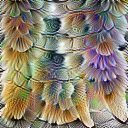

In [0]:
obj = objectives.neuron("mixed4c", 220)
_ = render.render_vis(model, obj)


obj = objectives.channel("mixed4c", 220)
_ = render.render_vis(model, obj)



filtro:100
1.8656193
512 772.0538



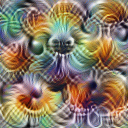

filtro:86
0.49315557
512 737.49445



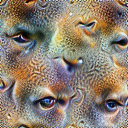

filtro:438
0.27340534
512 292.61227



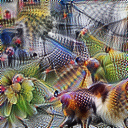

filtro:523
0.25032577
512 939.8131



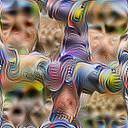

528


In [0]:
from lucid.misc.io import show, load

def score_f(logit, name):
  if name is None:
    return 0
  elif name == "logsumexp":
    base = tf.reduce_max(logit)
    return base + tf.log(tf.reduce_sum(tf.exp(logit-base)))
  elif name in model.labels:
    return logit[model.labels.index(name)]
  else:
    raise RuntimeError("Unsupported")
    
def channel_attr_simple(img, layer, class1, class2, n_show=4):

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session() as sess:
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Compute activations
    acts = T(layer).eval()
    
    # Compute gradient
    # descomentar si queremos ver las activaciones de la otra clase
    logit = T("softmax2_pre_activation")[0]
    score = score_f(logit, class1) #- score_f(logit, class2)
    t_grad = tf.gradients([score], [T(layer)])[0]
    grad = t_grad.eval()
    
    # Let's do a very simple linear approximation attribution.
    # That is, we say the attribution of y to x is 
    # the rate at which x changes y times the value of x.
    attr = (grad*acts)[0]
    
    # Then we reduce down to channels.
    channel_attr = attr.sum(0).sum(0)
    
    
  # Let's pick the most extreme channels to show
  ns_pos = list(np.argsort(-channel_attr)[:n_show])
  ns_neg = list(np.argsort(channel_attr)[:n_show][::-1])
  
  
  for n in ns_pos:
      print("filtro:"+str(n))
      print(channel_attr[n]) 
      obj = objectives.channel(layer, n)
      _ = render.render_vis(model, obj)
      
      
      
  
  
  print(len(channel_attr))
  
  
  
  
img = load("https://verding.es/wp-content/uploads/2016/11/serpiente-1280x622.jpg")
channel_attr_simple(img, "mixed4d", "tiger", "tiger cat", n_show=4)
